In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import matplotlib
from fourpop import fourpop
import scipy.io as io

### GRIK4 and D2 Thalamic Control

Using a four population model (two choice-selective excitatory populations and two inhibitory populations), how does decision making improve?
D2 neurons
Aim I. Test the hypothesis that the MD D2+ system is a locus for uncertainty estimates and task
prediction errors.
hypothesize that MD D2+ neurons respond to sparse sensory inputs from prefrontal afferents
and to negative reinforcement from subcortical afferents.

Aim II. Test the hypothesis that MD D2+ neurons encode latent rule uncertainty and task prediction errors
in a hierarchical decision task.
(cue vs rule uncertaintly).

We hypothesize that
these pathways are relevant for uncertainty susceptibility in schizophrenia, because each appears to respond to a
specific form of sensory uncertainty and to regulate a separate aspect of prefrontal switching associated with
latent uncertainty.

In [2]:
class fourpop():
    def __init__(self, GRIK4: float, D2: float,  p: dict = None):
        # Parameters
        if p != None:
            print("Using custom parameters")
            self.p = p
        else:
            print("No parameter dict given. Creating model with default parameters")
            default_params = self.default_params()
            self.p = default_params
            
        # set important attr from params
        self.NT = int(self.p['T']/self.p['dt'])
        self.dt = self.p['dt']
        self.timerange = np.linspace(0, self.p['T'], self.NT)
        self.GRIK4 = GRIK4
        self.D2 = D2
        
        # create background current array (since this comes up a lot)
        self.I0 = np.array([self.p['I0E'], self.p['I0E'], self.p['I0I'], self.p['I0I']])

        # create adjacency matrix
        self.A = self.adjacency()
    
    def default_params(self):
        p = {}
        # ---------- PARAMS ------------
        # firing rate 
        p['aE'] = 310
        p['bE'] = 125
        p['dE'] = 0.16

        p['aI'] = 615 
        p['bI'] = 177 
        p['dI'] = 0.087

        p['T'] = 7.      # [s]
        p['dt'] = 0.002  # [s]
        p['Tstim'] = 2.  # [s]
        p['Tdur']  = 2. # [s]

        p['sigma'] = 0.2       # nA
        p['tauN'] = 0.100      # slow excitatory synaptic time constant
        p['tauG'] = 0.005       # [s] inhibitory synaptic time constant
        p['tauA'] = 0.002        # [s]

        p['Jampa_ext'] = 5.2e-4 # nA
        p['mu'] = 40
        p['coh'] = 0

        p['gamma'] = 0.641   # firing rate to NMDA activation multiplier

        p['JNE'] = 0.42345756
        p['JNI'] = 0.57431432
        p['JGE'] = -0.46992407
        p['JGI'] = -0.64211589

        p['I0E'] = 0.77071143
        p['I0I'] = 1.02669666

        p['See'] = 0.32
        p['Sei'] = 0.25
        p['Sie'] = 0
        p['Sii'] = 0

        p['Ns'] = 2
        p['w_e'] = 1
        p['w_i'] = 1

        return p
    
    def update(self, **kwargs):
        # Update existing parameters
        self.p.update(kwargs)

    def adjacency(self):
        # calculate and return the input matrix
        p = self.p
        Ns = p['Ns']

        what_ee = Ns*p['w_e']/(Ns + p['See']*(2 - Ns)) 
        what_ei = Ns*p['w_e']/(Ns + p['Sei']*(2 - Ns)) 
        what_ie = Ns*p['w_i']/(Ns + p['Sie']*(2 - Ns)) 
        what_ii = Ns*p['w_i']/(Ns + p['Sii']*(2 - Ns)) 

        wpee = what_ee + p['See']*what_ee 
        wmee = what_ee - p['See']*what_ee 
        wpei = what_ei + p['Sei']*what_ei 
        wmei = what_ei - p['Sei']*what_ei 
        wpie = what_ie + p['Sie']*what_ie 
        wmie = what_ie - p['Sie']*what_ie 
        wpii = what_ii + p['Sii']*what_ii 
        wmii = what_ii - p['Sii']*what_ii 

        A = np.zeros([4,4]) 

        A[0,:] = [wpee*p['JNE'],wmee*p['JNE'],wpie*p['JGE'],wmie*p['JGE']]  #inputs to E1
        A[1,:] = [wmee*p['JNE'],wpee*p['JNE'],wmie*p['JGE'],wpie*p['JGE']]  #inputs to E2
        A[2,:] = [wpei*p['JNI'],wmei*p['JNI'],wpii*p['JGI'],wmii*p['JGI']]  #inputs to I1
        A[3,:] = [wmei*p['JNI'],wpei*p['JNI'],wmii*p['JGI'],wpii*p['JGI']]  #inputs to I2

        return A
    
    def run(self):
        def F(I, a, b, d):
            return (a*I - b)/(1 - np.exp(-d*(a*I - b)))
        
        NT = self.NT
        dt = self.dt
        A = self.A

        gwn = np.random.randn(4, NT)
        
        Ieta = np.zeros((4, NT+1))

        S = np.zeros((4, NT+1))
        S[0:2, 0] = (np.random.rand(2)*0.05 + 0.0)
        S[2:4, 0] = (np.random.rand(2)*0.05 + 0.275)
        
        r = np.zeros((4, NT))
        
        for t, time in enumerate(self.timerange): #Loop through time for a trial

            #---- Stimulus------------------------------------------------------
            Istim1  = ((self.p['Tstim']/dt < t) & (t<(self.p['Tstim']+self.p['Tdur'])/dt)) * (self.p['Jampa_ext']*self.p['mu']*(1+self.p['coh']/100)) # To population 1
            Istim2 = ((self.p['Tstim']/dt < t) & (t<(self.p['Tstim']+self.p['Tdur'])/dt)) * (self.p['Jampa_ext']*self.p['mu']*(1-self.p['coh']/100)) # To population 2
            Istim = np.array([Istim1, Istim2, 0., 0.])

            I0 = np.array([self.p['I0E'], self.p['I0E'], self.p['I0I'], self.p['I0I']])
            
            GRIK = np.array([0, 0, self.GRIK4*0.01, self.GRIK4*0.01])

            # Total synaptic input
            s_array = S[:,t]
            I = np.matmul(A, s_array) + I0 + Istim + GRIK + Ieta[:,t]

            # Transfer function to get firing rate
            r[0:2, t] = F(I[0:2], self.p['aE'], self.p['bE'], self.p['dE'])
            r[2:4, t] = F(I[2:4], self.p['aI'], self.p['bI'], self.p['dI'])
        
            #---- Dynamical equations -------------------------------------------

            # Mean synaptic dynamics updating
            S[0:2, t+1] = S[0:2,t] + dt*(-S[0:2,t]/self.p['tauN'] + (1-S[0:2,t])*self.p['gamma']*r[0:2,t])
            S[2:4,t+1] = S[2:4,t] + dt*(-S[2:4,t]/self.p['tauG'] + r[2:4,t])

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta[:, t+1] = Ieta[:,t] + (dt/self.p['tauA']) * (-Ieta[:,t]) + np.sqrt(self.p['tauA'])*self.p['sigma']*gwn[:,t]

        return {'r': r, 'S': S,
                't':self.timerange}
    
    def dsdt(self, s, ifstim=True):
        I_stim = np.zeros([4])
        x      = np.zeros([4])
        H      = np.zeros([4])
        dS     = np.zeros([4])

        GRIK = np.array([0, 0, self.GRIK4*0.01, self.GRIK4*0.01])

        # stim
        if ifstim:
            I_stim[0] = self.p['Jampa_ext'] * self.p['mu'] * (1+self.p['coh']/100) 
            I_stim[1] = self.p['Jampa_ext'] * self.p['mu'] * (1-self.p['coh']/100)

        # input
        x[:] = np.matmul(self.A,s) + self.I0 + I_stim + GRIK

        # freq
        H[0:2]  = (self.p['aE']*x[0:2] - self.p['bE'])/(1 - np.exp(-self.p['dE']*(self.p['aE']*x[0:2] - self.p['bE']))) 
        H[2:4]  = (self.p['aI']*x[2:4] - self.p['bI'])/(1 - np.exp(-self.p['dI']*(self.p['aI']*x[2:4] - self.p['bI']))) 

        # s
        dS[0:2] = -1*(self.p['tauN']**-1)*s[0:2] + (1-s[0:2])*self.p['gamma']*H[0:2]
        dS[2:4] = -1*(self.p['tauG']**-1)*s[2:4] + H[2:4]

        return dS
    
    def fourvar_jac(self, S, ifstim=True):
        # jacobian
        aE = self.p['aE']
        bE = self.p['bE']
        dE = self.p['dE']
        aI = self.p['aI']
        bI = self.p['bI']
        dI = self.p['dI']

        taus = np.array([self.p['tauN'], self.p['tauN'], self.p['tauG'], self.p['tauG']])
        GRIK = np.array([0, 0, self.GRIK4*0.01, self.GRIK4*0.01])

        I_stim = np.zeros([4])
        H      = np.zeros([4])
        
        dHds   = np.zeros([4,4])
        dsds   = np.zeros([4,4])
        
        if ifstim:
            I_stim[0] = self.p['Jampa_ext'] * self.p['mu'] * (1+self.p['coh']/100) 
            I_stim[1] = self.p['Jampa_ext'] * self.p['mu'] * (1-self.p['coh']/100)

        dxds = self.A

        x = np.matmul(self.A,S) + self.I0 + I_stim + GRIK
        H[0:2] = (aE*x[0:2] - bE)/(1 - np.exp(-dE*(aE*x[0:2] - bE))) 
        H[2:4] = (aI*x[2:4] - bI)/(1 - np.exp(-dI*(aI*x[2:4] - bI)))

        for i in range(4):
            dHds[0,i] = (aE*dxds[0,i]*(1 - np.exp(-dE*(aE*x[0]-bE))) - aE*dE*np.exp(-dE*(aE*x[0]-bE))*dxds[0,i]*(aE*x[0]-bE))/ ((1 - np.exp(-dE*(aE*x[0] - bE))))**2
            dHds[1,i] = (aE*dxds[1,i]*(1 - np.exp(-dE*(aE*x[1]-bE))) - aE*dE*np.exp(-dE*(aE*x[1]-bE))*dxds[1,i]*(aE*x[1]-bE))/ ((1 - np.exp(-dE*(aE*x[1] - bE))))**2
            dHds[2,i] = (aI*dxds[2,i]*(1 - np.exp(-dI*(aI*x[2]-bI))) - aI*dI*np.exp(-dI*(aI*x[2]-bI))*dxds[2,i]*(aI*x[2]-bI))/ ((1 - np.exp(-dI*(aI*x[2] - bI))))**2
            dHds[3,i] = (aI*dxds[3,i]*(1 - np.exp(-dI*(aI*x[3]-bI))) - aI*dI*np.exp(-dI*(aI*x[3]-bI))*dxds[3,i]*(aI*x[3]-bI))/ ((1 - np.exp(-dI*(aI*x[3] - bI))))**2

        dsds[0,0] = (-1/taus[0]) + self.p['gamma']*(-H[0] + dHds[0,0]*(1-S[0]))
        dsds[1,1] = (-1/taus[1]) + self.p['gamma']*(-H[1] + dHds[1,1]*(1-S[1]))
        dsds[2,2] = (-1/taus[2]) + dHds[2,2]
        dsds[3,3] = (-1/taus[3]) + dHds[3,3]

        for i in [0,1]:
            for j in range(4):
                if i != j:
                    dsds[i,j] = self.p['gamma']*(1-S[i])*dHds[i,j]
        for i in [2,3]:
            for j in range(4):
                if i != j:
                    dsds[i,j] = dHds[i,j]
        return dsds

    def get_fixed_points(self, ifstim):
        s = np.arange(0,1,0.1) # trial s values
        
        pts = []
        ddS  = []
        tol  = 1e-6     # tolerance
        stol = 1e-6

        for i in range(len(s)):
            for j in range(len(s)):
                # solve for solutions where dsdt = 0
                # Requires the corresponding jacobian.
                
                sol = optimize.fsolve(lambda s, ifstim: self.dsdt(s, ifstim), np.array([s[i],0.5,0.5,s[j]]), args=(ifstim), fprime=lambda s, ifstim: self.fourvar_jac(s, ifstim)) # returns the roots
                sol_ds = np.sqrt(np.sum(self.dsdt(sol, ifstim)**2)) # returns the magnitude of all the roots(?)

                if sol_ds < tol:
                    if (len(pts)>0):
                        if (np.any(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)):
                            for q,w in enumerate(np.where(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)[0]):
                                if sol_ds < ddS[w]:
                                    pts[w] = sol 
                                    ddS[w] = sol_ds
                        else:
                            pts.append(sol)
                            ddS.append(sol_ds)
                    else:
                        pts.append(sol)
                        ddS.append(sol_ds)

                sol = optimize.fsolve(lambda s, ifstim: self.dsdt(s, ifstim), np.array([0.5,s[i],s[j],0.5]), args=(ifstim), fprime=lambda s, ifstim: self.fourvar_jac(s, ifstim))
                sol_ds = np.sqrt(np.sum(self.dsdt(sol, ifstim)**2))
                
                if sol_ds < tol:
                    if (len(pts)>0):
                        if (np.any(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)):
                            for q,w in enumerate(np.where(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)[0]):
                                if sol_ds < ddS[w]:
                                    pts[w] = sol 
                                    ddS[w] = sol_ds
                        else:
                            pts.append(sol)
                            ddS.append(sol_ds)
                    else:
                        pts.append(sol)
                        ddS.append(sol_ds)
        pts   = np.array(pts)
        fps   = pts[np.isfinite(pts).all(axis=1),:]
        fps   = fps[np.argsort(fps[:,0]),:]
        stab  = np.zeros([fps.shape[0]])
        evals = [] 
        for i in range(fps.shape[0]):
            jac = self.fourvar_jac(fps[i], ifstim)
            if np.isfinite(jac).all():
                egs = np.linalg.eig(jac)
                evals.append(egs[0])
                if (egs[0]<0).all():
                    stab[i] = 1
            else:
                stab[i] = np.nan
                evals.append(np.array([np.nan]))
                
        return {'points':fps,'stable':stab,'eiganvalues':evals, 'dS':ddS}  



No parameter dict given. Creating model with default parameters


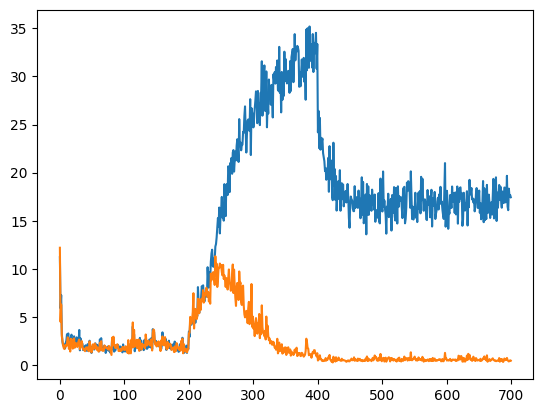

In [6]:
run1 = fourpop(GRIK4=0.2, D2=0)
dat1 = run1.run()
plt.plot(np.mean(dat1['r'][0].reshape(-1, 5), axis=1), color = )
plt.plot(np.mean(dat1['r'][1].reshape(-1,5), axis=1))

No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters


/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters
No parameter dict given. Creating model with default parameters


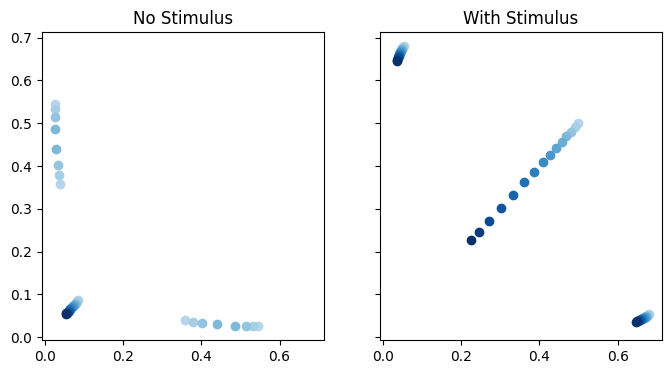

In [7]:
# what does increasing GRIK4 do?

GRIK4_array = np.linspace(0, 1.5, 15)

fig, axs = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True) 
axs[0].set(title='No Stimulus')
axs[1].set(title='With Stimulus')

cmap = [matplotlib.cm.get_cmap('Blues')(i) for i in np.linspace(0.3,1,15)]

for i, GRIK4 in enumerate(GRIK4_array[:]):
    sim = fourpop(GRIK4=GRIK4, D2=0)
    fp_u = sim.get_fixed_points(ifstim=False)['points'].T
    fp_s = sim.get_fixed_points(ifstim=True)['points'].T

    axs[0].scatter(fp_u[0], fp_u[1], c=[[cmap[i]]])
    axs[1].scatter(fp_s[0], fp_s[1], c=[[cmap[i]]])
    

### HYP: The unstable fixed point when stimulus is presented is a lot closer to the initial fixed point when GRIK4-PV inhibiton is high. BUT the stable decision attractors disappear. If the inhibition is timed such that it only occurs with the stimulus, then it could potentially help the decision making structure when there is low signal.

NameError: name 'tmpu' is not defined

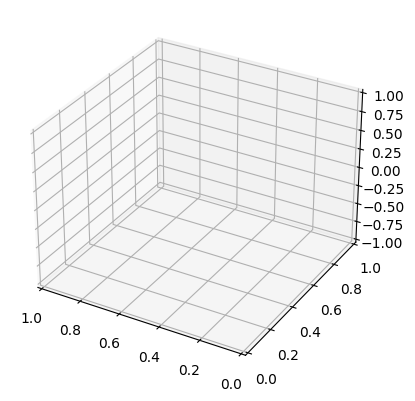

In [5]:
ax = plt.figure().add_subplot(projection='3d')
ax.set(xlim3d=(1,0), ylim3d=(0,1), zlim=(-1,1))
#tmpu['points'][0]
print(tmpu['stable'])
points = tmpu['points'].T
ax.scatter(points[0], points[1], points[3]-points[2])
